# REGRESSÃO LOGÍSTICA BINÁRIA

Os modelos de resposta qualitativa tem por objetivo estudar a probabilidade de ocorrência de um evento representado por Y que por sua vez é uma variável dicotómica, com base nas variáveis explicativas. O modelo é dado por:
$Z{i}=\alpha+\beta_{1} X_{1i}+\beta_{2} X_{2i}+...+\beta_{k} X_{ki}$.

Em que, $Z_{i}$ é conhecido por Logito, $\alpha$ a constante, $\beta_{k}$ são os parâmetros estimados de cada variável explicativa. $Z$ não representa a variável explicativa Y. O objetivo é definir a expressão da probabilidade $p_{i}$ de ocorrência do evento em função do Logito. A chance de ocorrência de um evento, também conhecida por odds, é dada por: 

$chance(odds)_{Yi=1}=\frac{p_{i}}{1-p_{i}}$. 

O Logito $Z$ é dado pelo Logarítmo natural da chance: $ln(\frac{p_{i}}{1-p_{i}})=Z_{i}$. Como o objetivo é definir a probabilidade, isola-se o $p_{i}$ da seguinte forma:

$p_{i}=\frac{e^{z_{i}}}{1+e^{z_{i}}}=\frac{1}{1+e^{-z_{i}}}$

Pode-se calcular o valor de $Z_{i}$ por meio da curva logística (sigmóide), estimando a probabilidade de ocorrência do evento. A expressão geral da probabiliade estimada de ocorrência de um evento dicotômico para observação i, é dado por:
$p_{i}=\frac{1}{1+e^{-(\alpha+\beta_{1} X_{1i}+\beta_{2} X_{2i}+...+\beta_{k} X_{ki})}}$

In [ ]:
import pandas as pd # manipulação de dado em formato de dataframe
import seaborn as sns # biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import statsmodels.api as sm # biblioteca de modelagem estatística
import numpy as np # biblioteca para operações matemáticas multidimensionais
import statsmodels.formula.api as smf

from statsmodels.discrete.discrete_model import MNLogit #modelo logístico multinomial
from scipy import stats

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(observado,predicts,cutoff):
    values = predicts.values
    predicao_binaria = []
    for item in values:
        if item >= cutoff:
            predicao_binaria.append(1)
        else:
            predicao_binaria.append(0)
    cm = confusion_matrix(observado, predicao_binaria)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)
    disp.plot()
    plt.title(f'Cutoff: {cutoff} \n Sensitividade(Recall): {round(sensitividade*100,2)}, \n Especificidade: {round(especificidadee*100,2)}, \n Acurácia: {round(acuracia*100,2)}')
    plt.show()
    return     

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1,0.001)
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    diff=[]
    for cutoff in cutoffs:
        predicao_binaria = []
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        diff.append(abs(sensitividade-especificidadee))
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade,'diff':diff})
    return resultado

In [ ]:
df_atrasado = pd.read_csv('/Atrasado.csv',delimiter=',')

#Características das variáveis do dataset
df_atrasado.info()

#Estatísticas univariadas
df_atrasado.describe()

#pd.get_dummies(data['column'],drop_first=True) #to get dumies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


## Significância estatística geral do modelo e dos parâmetros

Por se tratar de um modelo de resposta qualitativa, não faz sentido medir o percentual de variância que o modelo capta da variável objeto. 

- Nesse sentido, o Pseudo R² de McFadden, dado por: $R^2=\frac{2*LL_{0}-(2*LL_{Máx})}{2*LL_{0}}$. Diferente do R², ele mede o ganho do modelo máximizado em relação ao modelo nulo.
- A significância geral do modelo é dado pelo teste $\chi^{2}$ em que $H_{0}:  \beta_{1}=\beta_{2}=...=\beta_{k}=0$ e $H_{1}:$ existe ao menos um   $\beta_{j}<>0$. A estatística de teste é dada por: $\chi_{2}=-2(LL_{0}-LL_{máx})$ e os graus de liberdade é dado pela quantidade de parâmetros $\beta$.

- Para avaliar individualmente os parâmetros do modelo, utiliza-se a estatística z de Wald em que $H_{0}: \beta=0$ e $H_{1}<>0$ . A estatística de teste é dada por $z_{\beta}=\frac{\beta}{s.e(\beta)}$

In [ ]:
modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado,
                         family=sm.families.Binomial()).fit()
df_atrasado['phat'] = modelo_atrasos.predict()
modelo_atrasos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Fri, 24 Mar 2023   Deviance:                       100.93
Time:                        00:32:26   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.002     -42.712      -9.621
dist           0.1904      0.076      2.493      0.013       0.041       0.340
sem            2.3629      0.795      2.972      0.003       0.804       3.921
==============================================================================
"""

## Cutoffs e Metricas
**Cutoff:** Consiste em um limear para classificação. Logo, se $p_{i} > Cutoff$ a observação é classificada como evento.

Ao implementar o cutoff, gera-se uma matriz de confusão ao qual compara as classificações preditas com as classificações reais. Essa classificação gera alguns indicadores de eficiência do modelo que dependem do cutoff. são elas:

- **Eficiência Geral do modelo/Acurácia:** $\frac{TP+FP}{(TP+FP+TF+PF)}$, consiste no percentual de classificações positivas e negativas certas;
- **Sensitividade:** $\frac{TP+FP}{(TP+PF)}$, consiste no percentual de - classificações positivas que estão certas;
- **Especificidade:** $\frac{FP}{(FP+TF)}$, consiste no percentual de classificações negativas certas;

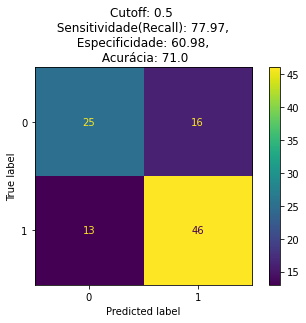

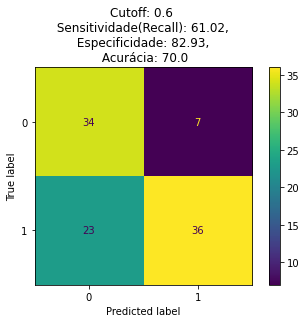

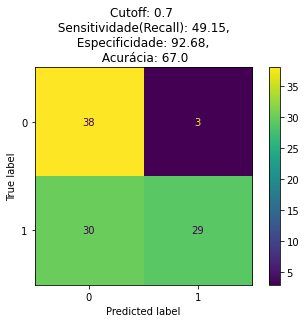

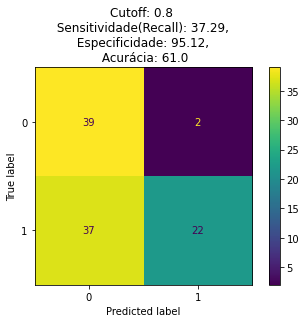

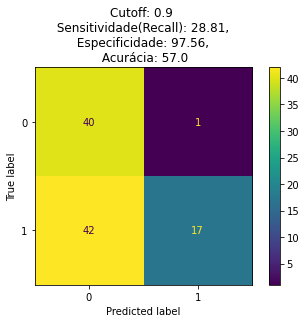

In [ ]:
#Matriz de confusão para diferentes cutoffs
for i in range(5,10):
  matriz_confusao(observado=df_atrasado['atrasado'],
                  predicts=df_atrasado['phat'], 
                  cutoff=(i/10))

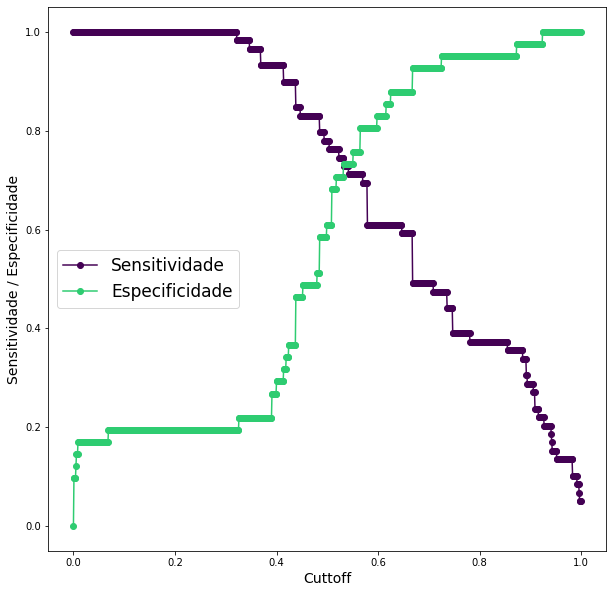

,cutoffs,sensitividade,especificidade,diff
532,0.532,0.728814,0.731707,0.002894
533,0.533,0.728814,0.731707,0.002894
534,0.534,0.728814,0.731707,0.002894
535,0.535,0.728814,0.731707,0.002894
536,0.536,0.728814,0.731707,0.002894
537,0.537,0.728814,0.731707,0.002894
538,0.538,0.728814,0.731707,0.002894
539,0.539,0.728814,0.731707,0.002894
540,0.540,0.728814,0.731707,0.002894
541,0.541,0.728814,0.731707,0.002894


In [ ]:
# Igualando Recall and Precision
dados_plotagem = espec_sens(observado = df_atrasado['atrasado'],
                            predicts = df_atrasado['phat'])
plt.figure(figsize=(10,10))
plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, '-o',
         color="#440154FF")
plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, '-o',
         color="#2ecc71")
plt.legend(['Sensitividade', 'Especificidade'], fontsize=17)
plt.xlabel("Cuttoff", fontsize=14)
plt.ylabel("Sensitividade / Especificidade", fontsize=14)
plt.show()

dados_plotagem[dados_plotagem['diff'] == dados_plotagem['diff'].min()]

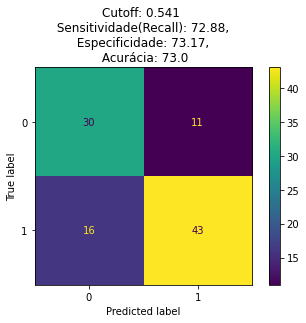

In [ ]:
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.541)

## Curva ROC
A curva ROC mostra o comportamento propriamente dito do trade eff entre sensitividade e especificidade e, ao trazer, no eixo das abscissas, os valores de (1 - especificidade), apresenta formato convexo em relação ao ponto (O, 1). Desta forma, um determinado modelo com maior área abaixo da curva ROC apresenta maior eficiência global de previsão, combinadas todas as possibilidades de cuteff e, assim, a sua escolha deve ser preferível quando da comparação com outro modelo com menor área abaixo da curva ROC. 

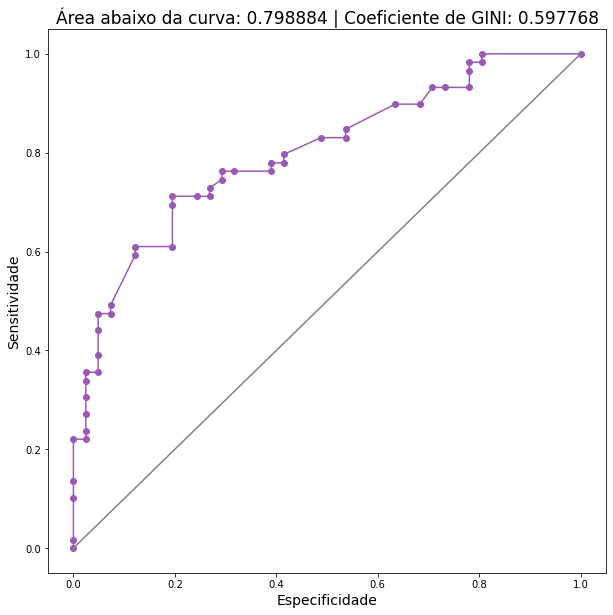

In [ ]:
from sklearn.metrics import roc_curve, auc

#Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_atrasado['atrasado'],df_atrasado['phat'])
roc_auc = auc(fpr, tpr)

#Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

#Plotando a curva ROC
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr, '-o', color="#9b59b6")
plt.plot(fpr,fpr, color='gray')
plt.title("Área abaixo da curva: %f" % roc_auc +
          " | Coeficiente de GINI: %f" % gini, fontsize=17)
plt.xlabel("Especificidade", fontsize=14)
plt.ylabel("Sensitividade", fontsize=14)
plt.show()

# REGRESSÃO LOGÍSTICA MUTINOMIAL

Quando a variável dependente é qualitativa porém oferece mais de duas possibilidades de resposta (categoria), faz-se uso da regressão logistica multinomial para estimar a probabilidade de ocorrência de cada alternativa. Primeiro define-se a categoria de referência. Suponde três categorias (0,1,2), seleciona-se a 0 como categoria de referencia, e tem-se duas outras possibilidade de eventos em relação a esta categoria, 1 e 2. Logo serão definidos dois verotres de variáveis explicativas com os respectivos parâmetros estimados, ou seja, dois logitos:

- $Z_{i1} = \alpha_{1} + \beta_{11} X_{1i} + \beta_{21} X_{2i}+...+\beta_{k1} X_{ki}$
- $Z_{i2}=\alpha_{2}+\beta_{12} X_{1i} +\beta_{22} X_{2i}+...+\beta_{k2} X_{ki}$

De maneira generica, se a variável de interesse representa M categorias, o número de logistos estimados será de (M-1) e, a partir dos mesmos é possível estimar as probabilidades de ocorrências de cada uma das categorias. A expressão geral do logito $Z_{im}$(m=0,1,...,M-1) é dado por:

- $Z_{im} = \alpha_{m}+\beta_{1m} X_{1i} \beta_{2m} X_{2i }+ ... + \beta_{km} X_{ki}$

A probabilidade de ocorrência de evento para três categorias é dada por:
- Categoria 0: $(p_{i0})=\frac{1}{1+e^{Z_{i1}}+e^{Z_{i2}}}$
- Categoria 1: $(p_{i1})=\frac{e^{Z_{i1}}}{1+e^{Z_{i1}}+e^{Z_{i2}}}$
- Categoria 2: $(p_{i2})=\frac{e^{Z_{i2}}}{1+e^{Z_{i1}}+e^{Z_{i2}}}$

De modo geral, para um modelo que a variável dependente assume M categorias de resposta, pode-se escrever a probabilidade de ocorrência das categorias da seguinte forma:
- $(p_{im})=\frac{e^{Z_{im}}}{\sum\limits_{m=0}^{M-1}(e^{Z_{im}})}$

A estimação dos parâmetros das expressões de probabilidade é feita através de Máxima Verossimilhança em que a variável dependente segue uma distribuição binomial. Dada as M categorias das variáveis dependentes, quais valores dos parâmetros dos logitos fazem com que o valor de LL sejam maximizado?

In [ ]:
df_atrasado_multinomial = pd.read_csv('/content/drive/MyDrive/1- USP ESALQ/2- Módulo 1/2- SUPERVISED MACHINE LEARNING/02 - Análise de Modelos Logísticos Binários e Multinomiais I/atrasado_multinomial.csv',delimiter=',')
#Características das variáveis do dataset
df_atrasado_multinomial.info()

#Estatísticas univariadas
df_atrasado_multinomial.describe()

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'nao chegou atrasado',
                            'atrasado2'] = 0 #categoria de referência
df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado primeira aula',
                            'atrasado2'] = 1
df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado segunda aula',
                            'atrasado2'] = 2

df_atrasado_multinomial['atrasado2'] =\
    df_atrasado_multinomial['atrasado2'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    object 
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ KB


In [ ]:
x = df_atrasado_multinomial.drop(columns=['estudante','atrasado','atrasado2'])
y = df_atrasado_multinomial['atrasado2']

#Esse pacote precisa que a constante seja definida pelo usuário
X = sm.add_constant(x)

#Estimação do modelo - função 'MNLogit' do pacote
#'statsmodels.discrete.discrete_model'
modelo_atrasado = MNLogit(endog=y, exog=X).fit()

#Parâmetros do modelo
modelo_atrasado.summary()

phats = pd.DataFrame(modelo_atrasado.predict()) # probabilidade das 3 categorias
df_atrasado_multinomial = pd.concat([df_atrasado_multinomial, phats], axis=1) #add probl
df_atrasado_multinomial['predicao'] = phats.idxmax(axis=1)
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==0,
                            'predicao_label'] ='não chegou atrasado'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==1,
                            'predicao_label'] ='chegou atrasado primeira aula'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==2,
                            'predicao_label'] ='chegou atrasado segunda aula'

df_atrasado_multinomial

Optimization terminated successfully.
         Current function value: 0.245118
         Iterations 10


,estudante,atrasado,dist,sem,atrasado2,0,1,2,predicao,predicao_label
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2,1.801024e-02,0.523388,4.586018e-01,1,chegou atrasado primeira aula
1,Patricia,chegou atrasado segunda aula,21.299999,18,2,2.751301e-06,0.018737,9.812605e-01,2,chegou atrasado segunda aula
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2,6.796190e-04,0.173472,8.258489e-01,2,chegou atrasado segunda aula
3,Leticia,chegou atrasado segunda aula,31.500000,15,2,2.759476e-07,0.003748,9.962518e-01,2,chegou atrasado segunda aula
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2,2.083782e-02,0.601588,3.775739e-01,1,chegou atrasado primeira aula
...,...,...,...,...,...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0,9.531361e-01,0.046317,5.471598e-04,0,não chegou atrasado
96,Pedro,chegou atrasado primeira aula,15.000000,15,1,4.146183e-01,0.557343,2.803830e-02,1,chegou atrasado primeira aula
97,Horacio,chegou atrasado primeira aula,14.400000,15,1,5.008256e-01,0.481441,1.773339e-02,0,não chegou atrasado
98,Leandro,chegou atrasado segunda aula,22.200001,18,2,1.049763e-06,0.011822,9.881774e-01,2,chegou atrasado segunda aula


In [ ]:
def Qui2(modelo_multinomial):
    maximo = modelo_multinomial.llf
    minimo = modelo_multinomial.llnull
    qui2 = -2*(minimo - maximo)
    pvalue = stats.distributions.chi2.sf(qui2,1)
    df = pd.DataFrame({'Qui quadrado':[qui2],
                       'pvalue':[pvalue]})
    return df

Qui2(modelo_atrasado)

,Qui quadrado,pvalue
0,153.014842,3.802150e-35


In [ ]:
#Criando uma tabela para comparar as ocorrências reais com as predições
table = pd.pivot_table(df_atrasado_multinomial,
                       index=['predicao_label'],
                       columns=['atrasado'],
                       aggfunc='size')
table = table.fillna(0)
table = table.to_numpy()
#Eficiência global do modelo
acuracia = table.diagonal().sum()/table.sum()
print('Acurácia: ',acuracia)
table

Acurácia:  0.89


array([[12.,  5.,  2.],
       [ 3., 30.,  0.],
       [ 1.,  0., 47.]])